# MAML Tutorial with JAX

Eric Jang

Blog post: https://blog.evjang.com/2019/02/maml-jax.html


21 Feb 2019

Pedagogical tutorial for implementing Model-Agnostic Meta-Learning with JAX's awesome `grad` and `vmap` and `jit` operators.

## Overview

In this notebook we'll go through:

- how to take gradients, gradients of gradients.
- how to fit a sinusoid function with a neural network (and do auto-batching with vmap)
- how to implement MAML and check its numerics
- how to implement MAML for sinusoid task (single-task objective, batching task instances).
- extending MAML to handle batching at the task-level


In [0]:
### import jax.numpy (almost-drop-in for numpy) and gradient operators.
import jax.numpy as np
from jax import grad

## Gradients of Gradients

JAX makes it easy to compute gradients of python functions. Here, we thrice-differentiate $e^x$ and $x^2$

In [0]:
f = lambda x : np.exp(x)
g = lambda x : np.square(x)
print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0

2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


## Sinusoid Regression and vmap

To get you familiar with JAX syntax first, we'll optimize neural network params with fixed inputs on a mean-squared error loss to $f_\theta(x) = sin(x)$.

In [0]:
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax import random # stax initialization uses jax.random
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers
import matplotlib.pyplot as plt # visualization

In [0]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

rng = random.PRNGKey(123)
in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

In [0]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

(100, 1) (100, 1)
(100,)


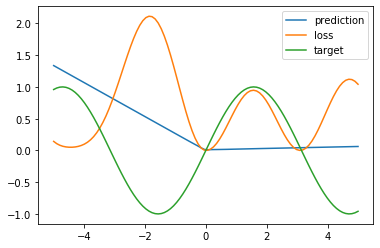

In [0]:
# batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
print(xrange_inputs.shape, targets.shape)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params), in_axes=(0,0))(xrange_inputs, targets) # per-input loss
# losses = loss(net_params, xrange_inputs, targets) # per-input loss
print(losses.shape)
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [0]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

# Define a compiled update step
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(loss)(p, x1, y1)
    return opt_update(i, g, opt_state)

for i in range(100):
    opt_state = step(i, opt_state, xrange_inputs, targets)
net_params = get_params(opt_state)

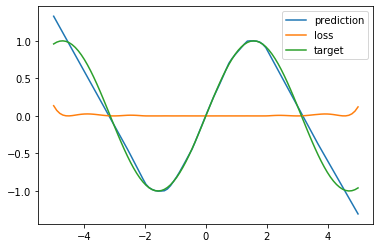

In [0]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

## MAML: Optimizing for Generalization

Suppose task loss function $\mathcal{L}$ is defined with respect to model parameters $\theta$, input features $X$, input labels $Y$. MAML optimizes the following:

$\mathcal{L}(\theta - \nabla \mathcal{L}(\theta, x_1, y_1), x_2, y_2)$

$x_1, y_2$ and $x_2, y_2$ are identically distributed from $X, Y$. Therefore, MAML objective can be thought of as a differentiable cross-validation error (w.r.t. $x_2, y_2$) for a model that learns (via a single gradient descent step) from $x_1, y_1$. Minimizing cross-validation error provides an inductive bias on generalization.

The following toy example checks MAML numerics via parameter $x$ and input $y$.

In [0]:
# gradients of gradients test for MAML
# check numerics
g = lambda x, y : np.square(x) + y
x0 = 2.
y0 = 1.
print('grad(g)(x0) = {}'.format(grad(g)(x0, y0))) # 2x = 4
print('x0 - grad(g)(x0) = {}'.format(x0 - grad(g)(x0, y0))) # x - 2x = -2
def maml_objective(x, y):
    return g(x - grad(g)(x, y), y)
print('maml_objective(x,y)={}'.format(maml_objective(x0, y0))) # x**2 + 1 = 5
print('x0 - maml_objective(x,y) = {}'.format(x0 - grad(maml_objective)(x0, y0))) # x - (2x)

grad(g)(x0) = 4.0
x0 - grad(g)(x0) = -2.0
maml_objective(x,y)=5.0
x0 - maml_objective(x,y) = -2.0


## Sinusoid Task + MAML


Now let's re-implement the Sinusoidal regression task from Chelsea Finn's [MAML paper](https://arxiv.org/abs/1703.03400).


In [0]:
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [0]:
x1 = xrange_inputs
y1 = targets
x2 = np.array([0.])
y2 = np.array([0.])
maml_loss(net_params, x1, y1, x2, y2)

DeviceArray(3.9853594e-06, dtype=float32)

Let's try minimizing the MAML loss (without batching across multiple tasks, which we will do in the next section)


In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

# Adam optimization
for i in range(100000):
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 10000 == 0:
        print(i)
net_params = get_params(opt_state)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


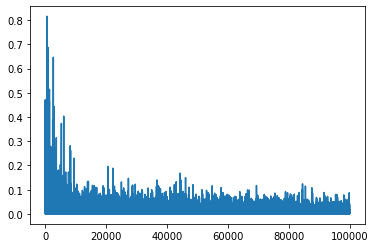

In [0]:
plt.plot(np_maml_loss)

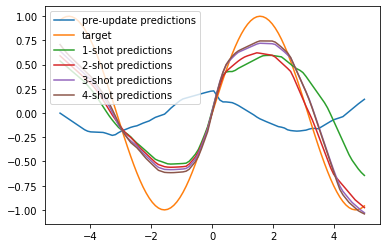

In [0]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    # predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    predictions = net_apply(net_params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

## Batching Meta-Gradient Across Tasks

Kind of does the job but not that great. Let's reduce the variance of gradients in outer loop by averaging across a batch of tasks (not just one task at a time). 

vmap is awesome it enables nice handling of batching at two levels: inner-level "intra-task" batching, and outer level batching across tasks.

From a software engineering perspective, it is nice because the "task-batched" MAML implementation simply re-uses code from the non-task batched MAML algorithm, without losing any vectorization benefits.

In [0]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

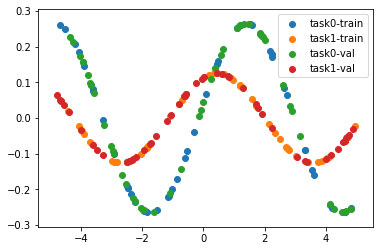

In [0]:
outer_batch_size = 2
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [0]:
x2.shape

(2, 50, 1)

In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(100000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 10000 == 0:
        print(i)
net_params = get_params(opt_state)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


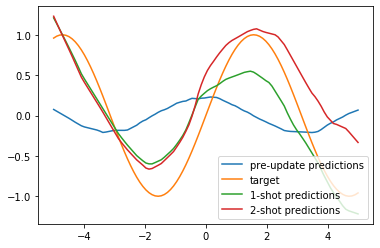

In [0]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,3):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


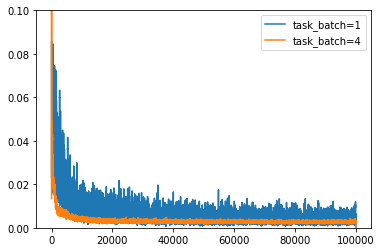

In [0]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05]*20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=4')
plt.ylim(0., 1e-1)
plt.legend()

In [0]:
print(np.average(np_maml_loss), np.average(np_batched_maml_loss))

0.0069666305 0.0033994368
